In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from IPython import display

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

from keras.engine.keras_tensor import KerasTensor
from typing import Tuple
import shutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
FILE_PATH_BASE = '/kaggle/input/gan-getting-started'
MONET_FILENAMES = [f'{FILE_PATH_BASE}/monet_tfrec/{f}' for f in os.listdir(f'{FILE_PATH_BASE}/monet_tfrec')]
PHOTO_FILENAMES = [f'{FILE_PATH_BASE}/photo_tfrec/{f}' for f in os.listdir(f'{FILE_PATH_BASE}/photo_tfrec')]
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = (256, 256)
checkpoint_path = '/kaggle/working/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
weights = '/kaggle/input/weights-monet/checkpoint'
f'Monet tfrec total files: {len(MONET_FILENAMES)}, total tfrec photos: {len(PHOTO_FILENAMES)}'

'Monet tfrec total files: 5, total tfrec photos: 20'

In [3]:
def set_strategy(option: str= None):
    strategy = None
    if option == 'gpu':
        try:
            gpus = tf.config.list_logical_devices('GPU')
            print("Number of available GPUs: ", len(gpus))
            strategy = tf.distribute.MirroredStrategy(gpus)
        except:
            strategy = tf.distribute.get_strategy()
    if option == 'tpu':
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print('Device:', tpu.master())
            tf.config.experimental_connect_to_cluster(tpu)
            tpus = tf.tpu.experimental.initialize_tpu_system(tpu)
            print(tpus)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
        except:
            strategy = tf.distribute.get_strategy()
    if option == None:
        strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)
    return strategy

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    return tf.reshape(img, [*IMAGE_SIZE, 3])

# EDA

In [4]:
RAW_MONET_DATASET = tf.data.TFRecordDataset(MONET_FILENAMES)
RAW_PHOTOS_DATASET = tf.data.TFRecordDataset(PHOTO_FILENAMES)

FILE_PROPS = {
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string)
}

MONET_DATASET = RAW_MONET_DATASET.map(
    lambda x: decode_image(
        tf.io.parse_single_example(x, FILE_PROPS)['image']
    ), 
    num_parallel_calls=AUTOTUNE
).batch(1)

PHOTOS_DATASET = RAW_PHOTOS_DATASET.map(
    lambda x: decode_image(
        tf.io.parse_single_example(x, FILE_PROPS)['image']
    ), 
    num_parallel_calls=AUTOTUNE
).batch(1)

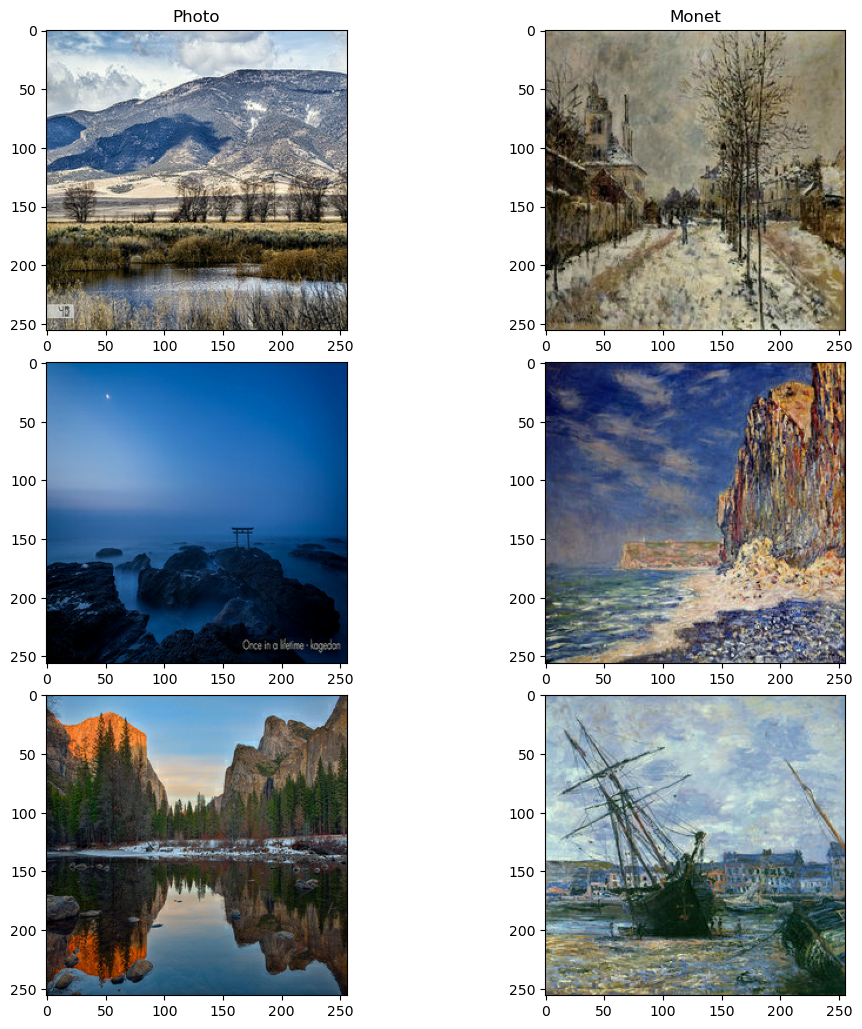

In [5]:
n = 3
fig, axarr = plt.subplots(n,2, figsize=(10, 10))
fig.tight_layout(pad=0.2)
for idx, (p, m) in enumerate(zip(PHOTOS_DATASET.take(n),MONET_DATASET.take(n))):
    axarr[idx,0].imshow(p[0] * 0.5 + 0.5)
    msp = axarr[idx,1].imshow(m[0] * 0.5 + 0.5)
    if idx < 1:
        axarr[idx,0].title.set_text('Photo')
        axarr[idx,1].title.set_text('Monet')
plt.show()

In [6]:
class Down_Sampler:
    def __init__(self, x: keras.layers.Input, filters: int, kernel_size: int, strides: int = 2, with_instance_normalization: bool = True, mean: float=0.0, stddev: float=0.2)->None:
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.is_normalized = with_instance_normalization
        self.mean = mean
        self.stddev = stddev
        self.x = self.build_components(x)
        
    def build_components(self,  x: keras.layers.Input)->KerasTensor:
        x = layers.Conv2D(
            self.filters, 
            self.kernel_size, 
            strides=self.strides, 
            padding='same', 
            kernel_initializer=tf.random_normal_initializer(self.mean, self.stddev),
            use_bias=False
        )(x)
        if self.is_normalized:
            x = tfa.layers.InstanceNormalization(
                gamma_initializer=keras.initializers.RandomNormal(mean=self.mean, stddev=self.stddev)
            )(x)
        x = layers.LeakyReLU()(x)
        return x
    

class Up_Sampler:
    def __init__(self, x: keras.layers.Input, filters: int, kernel_size: int, strides: int = 2, with_dropout: bool = False, mean: float=0.0, stddev: float=0.2)->None:
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.has_dropout = with_dropout
        self.mean = mean
        self.stddev = stddev
        self.x = self.build_components(x)
        
    def build_components(self,  x: keras.layers.Input)->KerasTensor:
        x = layers.Conv2DTranspose(
            self.filters, 
            self.kernel_size, 
            strides=self.strides, 
            padding='same', 
            kernel_initializer=tf.random_normal_initializer(self.mean, self.stddev),
            use_bias=False
        )(x)
        x = tfa.layers.InstanceNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=self.mean, stddev=self.stddev)
        )(x)
        if self.has_dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.ReLU()(x)
        return x

class UNET_Generator:
    def __init__(self, name: str, input_shape: Tuple[int, int, int], output_channels: int = 3, kernel_size: int = 4, strides: int = 2, optimizer = None):
        self.name = name
        self.inputs = layers.Input(shape=input_shape)
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.model = self.build_model()
        self.optimizer = optimizer
        
    def build_model(self)->keras.Model:
        x = self.inputs
        kernel_size = self.kernel_size
        strides = self.strides
        d1 = Down_Sampler(x, 64, kernel_size=kernel_size, strides=self.strides, with_instance_normalization=False).x
        d2 = Down_Sampler(d1, 128, kernel_size=kernel_size, strides=strides).x
        d3 = Down_Sampler(d2, 256, kernel_size=kernel_size, strides=strides).x
        d4 = Down_Sampler(d3, 512, kernel_size=kernel_size, strides=strides).x
        d5 = Down_Sampler(d4, 512, kernel_size=kernel_size, strides=strides).x
        d6 = Down_Sampler(d5, 512, kernel_size=kernel_size, strides=strides).x
        d7 = Down_Sampler(d6, 512, kernel_size=kernel_size, strides=strides).x
        d8 = Down_Sampler(d7, 512, kernel_size=kernel_size, strides=strides).x
        u1 = Up_Sampler(d8, 512, kernel_size=kernel_size, strides=strides, with_dropout=True).x
        s1 = layers.Concatenate()([u1,d7])
        u2 = Up_Sampler(s1, 512, kernel_size=kernel_size, strides=strides, with_dropout=True).x
        s2 = layers.Concatenate()([u2,d6])
        u3 = Up_Sampler(s2, 512, kernel_size=kernel_size, strides=strides, with_dropout=True).x
        s3 = layers.Concatenate()([u3,d5])
        u4 = Up_Sampler(s3, 512, kernel_size=kernel_size, strides=strides).x
        s4 = layers.Concatenate()([u4,d4])
        u5 = Up_Sampler(s4, 256, kernel_size=kernel_size, strides=strides).x
        s5 = layers.Concatenate()([u5,d3])
        u6 = Up_Sampler(s5, 128, kernel_size=kernel_size, strides=strides).x
        s6 = layers.Concatenate()([u6,d2])
        u7 = Up_Sampler(s6, 64, kernel_size=kernel_size, strides=strides).x
        s7 = layers.Concatenate()([u7,d1])
        final_layer = layers.Conv2DTranspose(
            self.output_channels, 
            kernel_size,
            strides=strides,
            padding='same',
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation='tanh'
        )(s7)
        return keras.Model(inputs=self.inputs, outputs=final_layer, name=self.name)
    
    def calculate_loss(self, fake):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(
            tf.ones_like(fake), fake
        )
        
class Discriminator:
    def __init__(self, name: str, input_shape: Tuple[int, int, int], output_channels: int = 3, kernel_size: int = 4, strides: int = 2, optimizer=None)->None:
        self.name = name
        self.inputs = layers.Input(shape=input_shape)
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.model = self.build_model()
        self.optimizer = optimizer
    
    def build_model(self)->keras.Model:
        x = self.inputs
        kernel_size = self.kernel_size
        strides = self.strides
        d1 = Down_Sampler(self.inputs, 64, kernel_size=kernel_size, strides=self.strides, with_instance_normalization=False).x
        d2 = Down_Sampler(d1, 128, kernel_size=kernel_size, strides=self.strides).x
        d3 = Down_Sampler(d2, 256, kernel_size=kernel_size, strides=self.strides).x
        zp1 = layers.ZeroPadding2D()(d3)
        c1 = layers.Conv2D(
            512, 4, 
            strides=1,
            kernel_initializer=tf.random_normal_initializer(0.0, 0.02),
            use_bias=False
        )(zp1)
        n1 = tfa.layers.InstanceNormalization(
            gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        )(c1)
        lr = layers.LeakyReLU()(n1)
        zp2 = layers.ZeroPadding2D()(lr)
        final_layer = layers.Conv2D(1,4, strides=1,kernel_initializer=tf.random_normal_initializer(0.0, 0.02))(zp2)
        return keras.Model(inputs=self.inputs, outputs=final_layer, name=self.name)

    def calculate_loss(self, true, fake):
        true_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(true), true)
        
        fake_loss = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, 
            reduction=tf.keras.losses.Reduction.NONE
        )(tf.ones_like(fake), fake)
        
        return  (true_loss + fake_loss) * 0.5
    


In [7]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss
    
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


In [8]:
strategy = set_strategy('gpu')
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True,verbose=1)

with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_gen = UNET_Generator(name='Monet_Generator',input_shape=(256,256,3), optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5)).model
    photo_gen = UNET_Generator(name='Photo_Generator',input_shape=(256,256,3), optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5)).model
    monet_dscr = Discriminator(name='Monet_Discriminator', input_shape=(256, 256,3), optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5)).model
    photo_dscr = Discriminator(name='Photo_Discriminator', input_shape=(256, 256,3), optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5)).model
    cycle_gan_model = CycleGan(
        monet_gen, photo_gen, monet_dscr, photo_dscr
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )    

Number of available GPUs:  1
Number of replicas: 1


In [9]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((MONET_DATASET, PHOTOS_DATASET)),
    epochs=30,
    verbose=1,
    callbacks=[cp_callback]
)
history

Epoch 1/30


2023-10-15 06:20:03.057414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inPhoto_Generator/dropout_3/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    300/Unknown - 136s 251ms/step - monet_gen_loss: 4.1674 - photo_gen_loss: 4.2002 - monet_disc_loss: 0.6219 - photo_disc_loss: 0.6488
Epoch 1: saving model to /kaggle/working/cp.ckpt
300/300 [==============================] - 142s 271ms/step - monet_gen_loss: 4.1646 - photo_gen_loss: 4.1982 - monet_disc_loss: 0.6223 - photo_disc_loss: 0.6489
Epoch 2/30
300/300 [==============================] - ETA: 0s - monet_gen_loss: 3.1200 - photo_gen_loss: 3.0671 - monet_disc_loss: 0.6064 - photo_disc_loss: 0.6283
Epoch 2: saving model to /kaggle/working/cp.ckpt
300/300 [==============================] - 82s 273ms/step - monet_gen_loss: 3.1187 - photo_gen_loss: 3.0672 - monet_disc_loss: 0.6070 - photo_disc_loss: 0.6284
Epoch 3/30
300/300 [==============================] - ETA: 0s - monet_gen_loss: 2.9165 - photo_gen_loss: 2.8684 - monet_disc_loss: 0.5922 - photo_disc_loss: 0.6115
Epoch 3: saving model to /kaggle/working/cp.ckpt
300/300 [==============================] - 81s 271ms/step - monet_ge

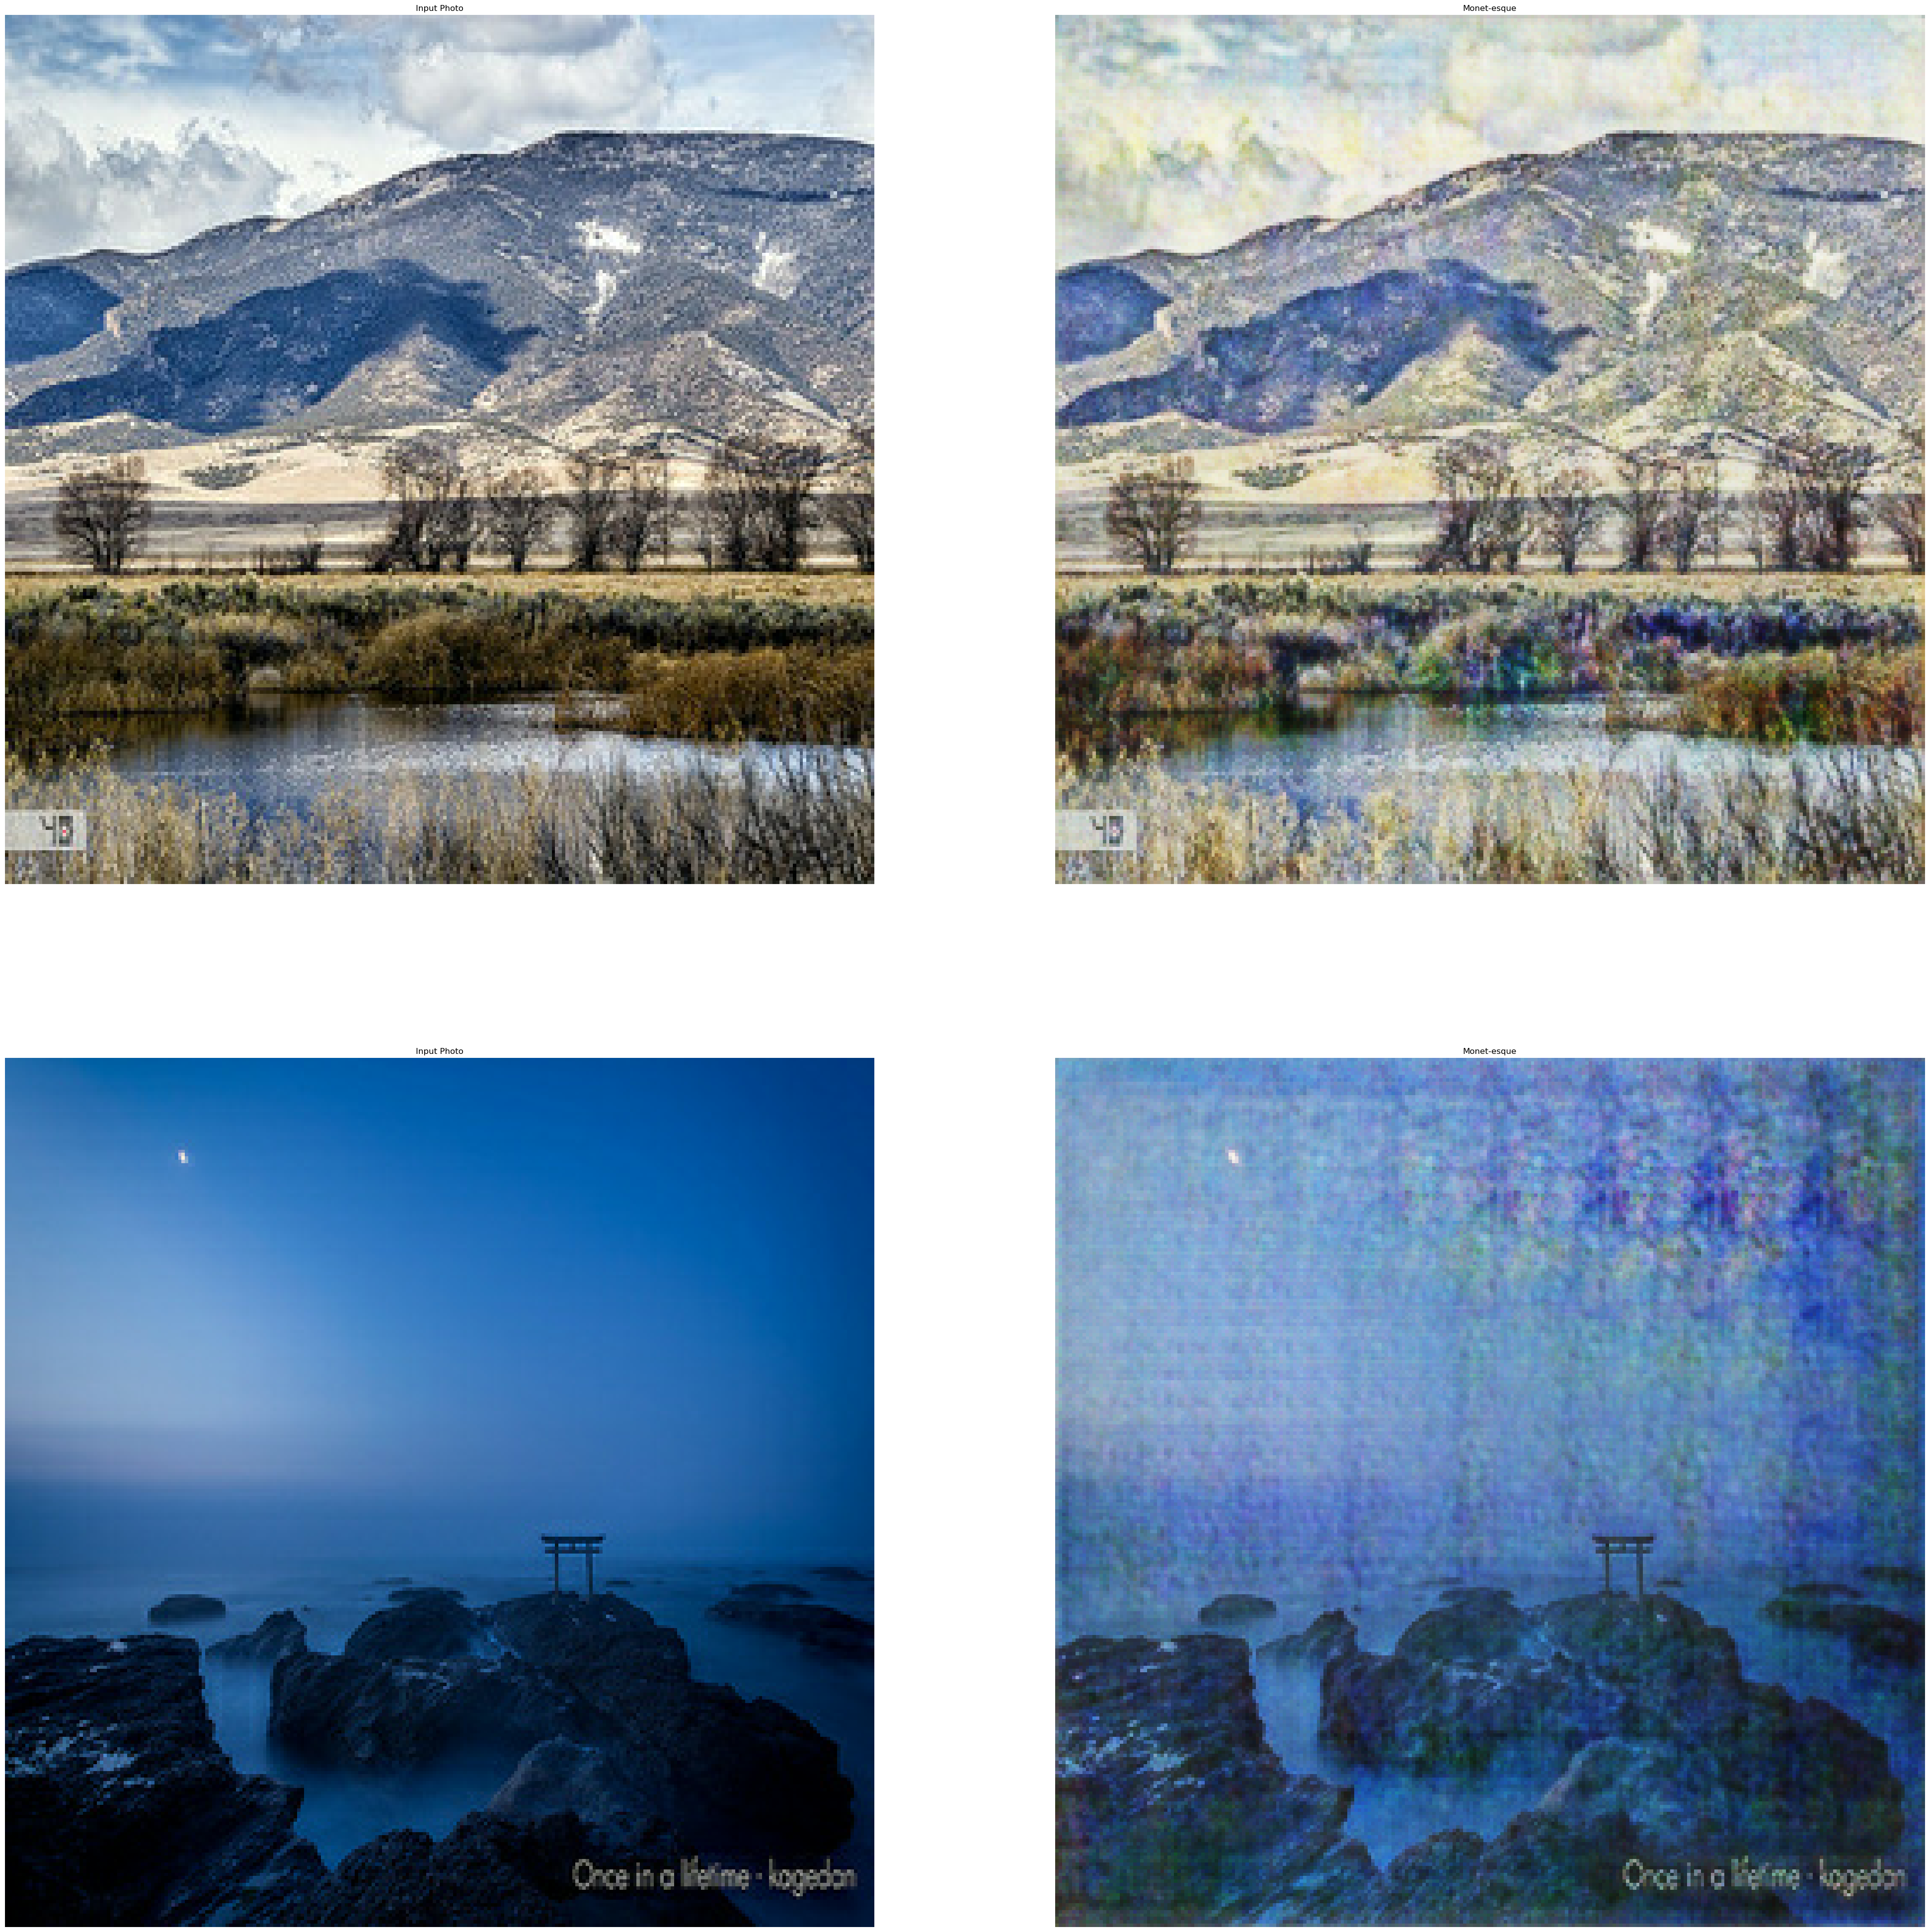

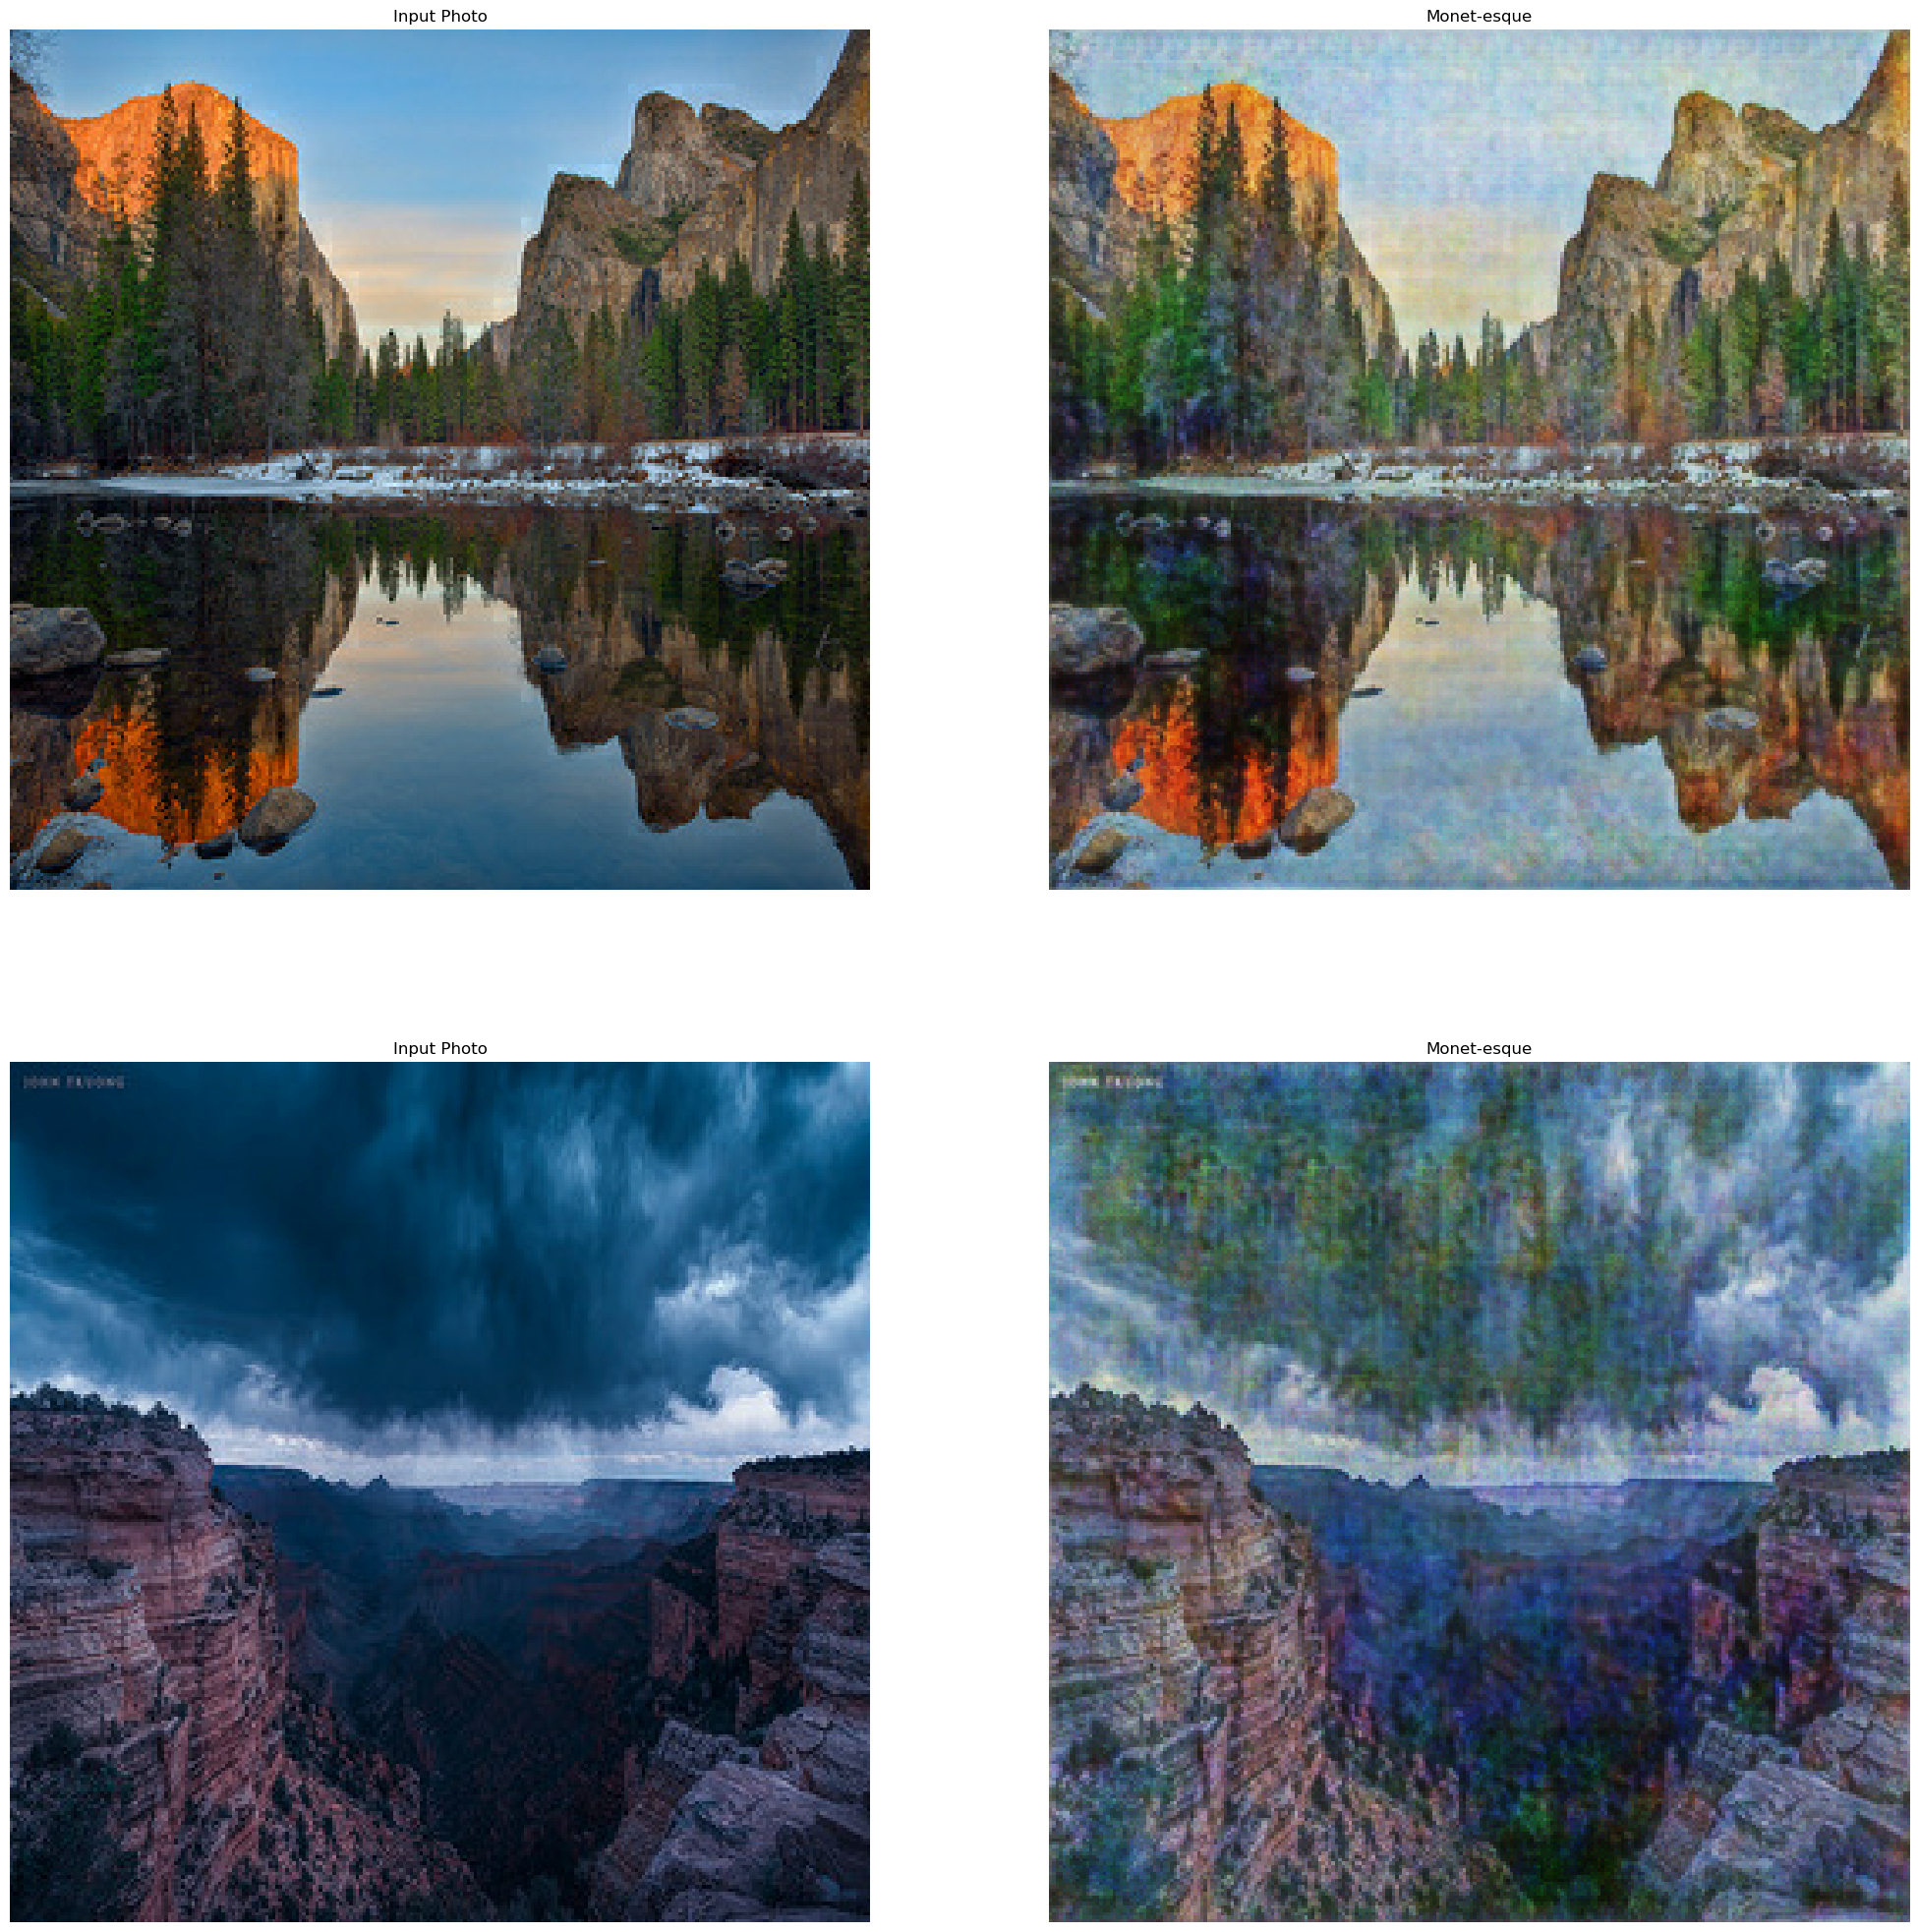

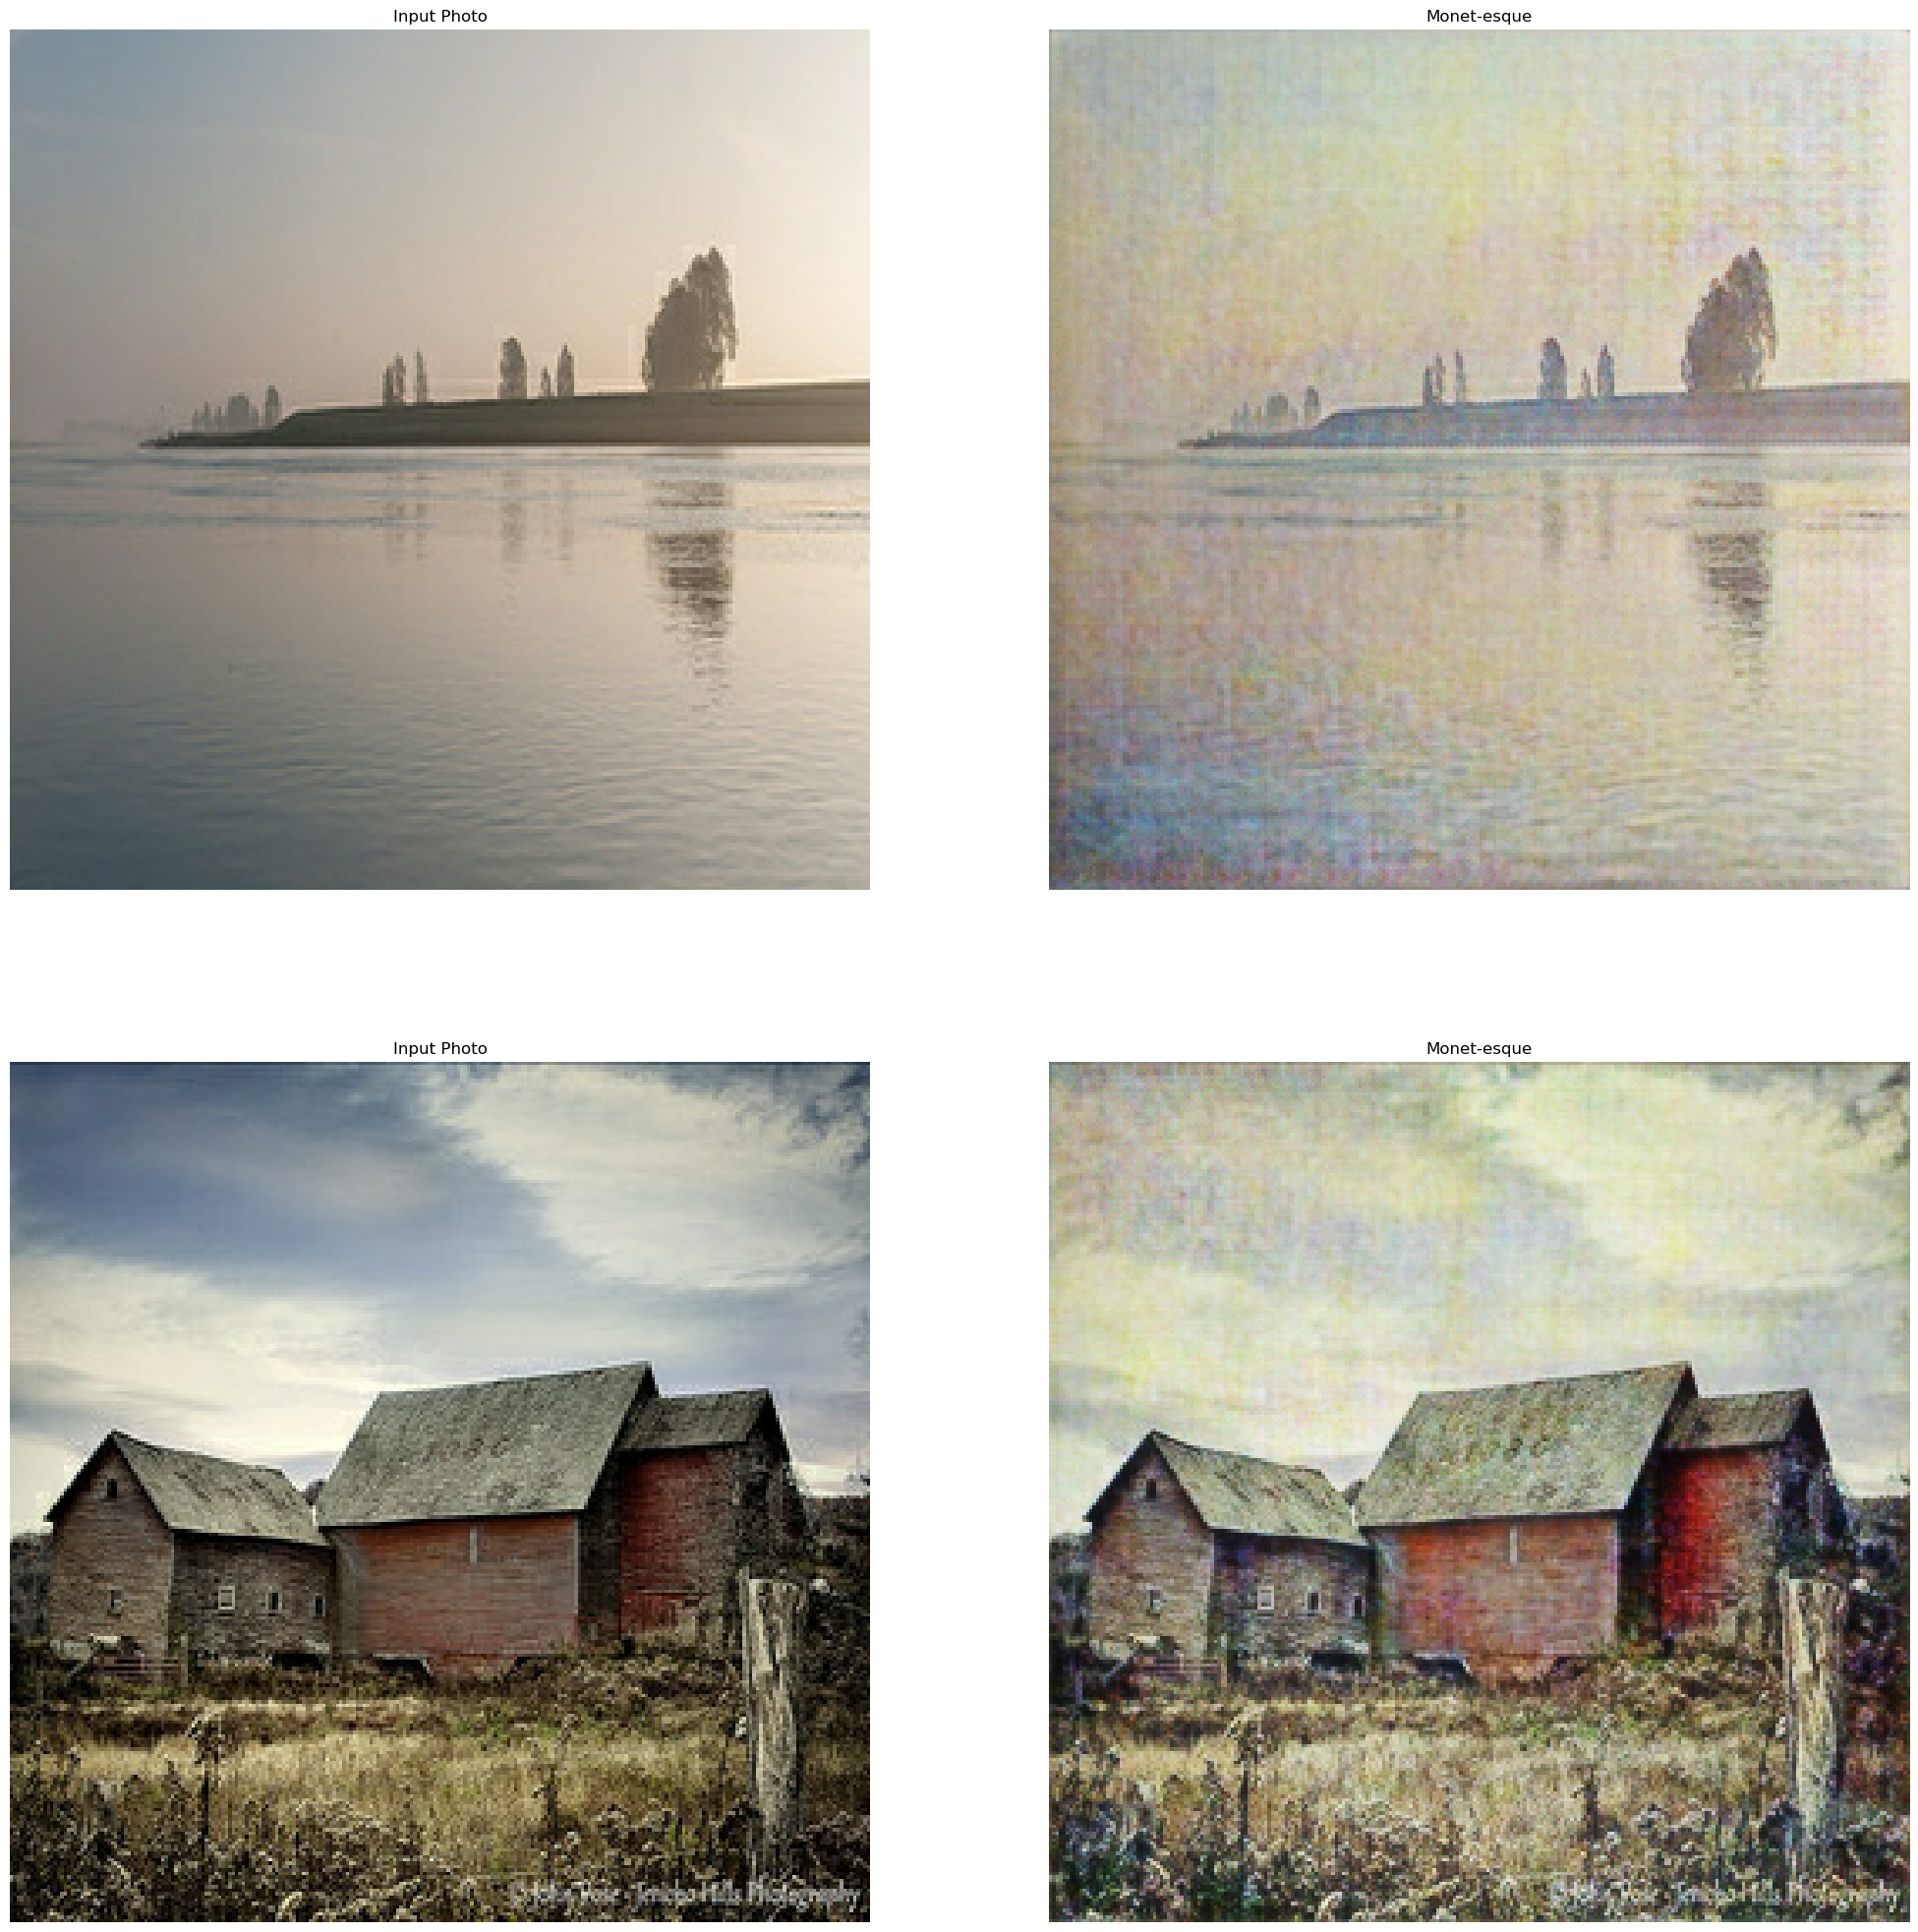

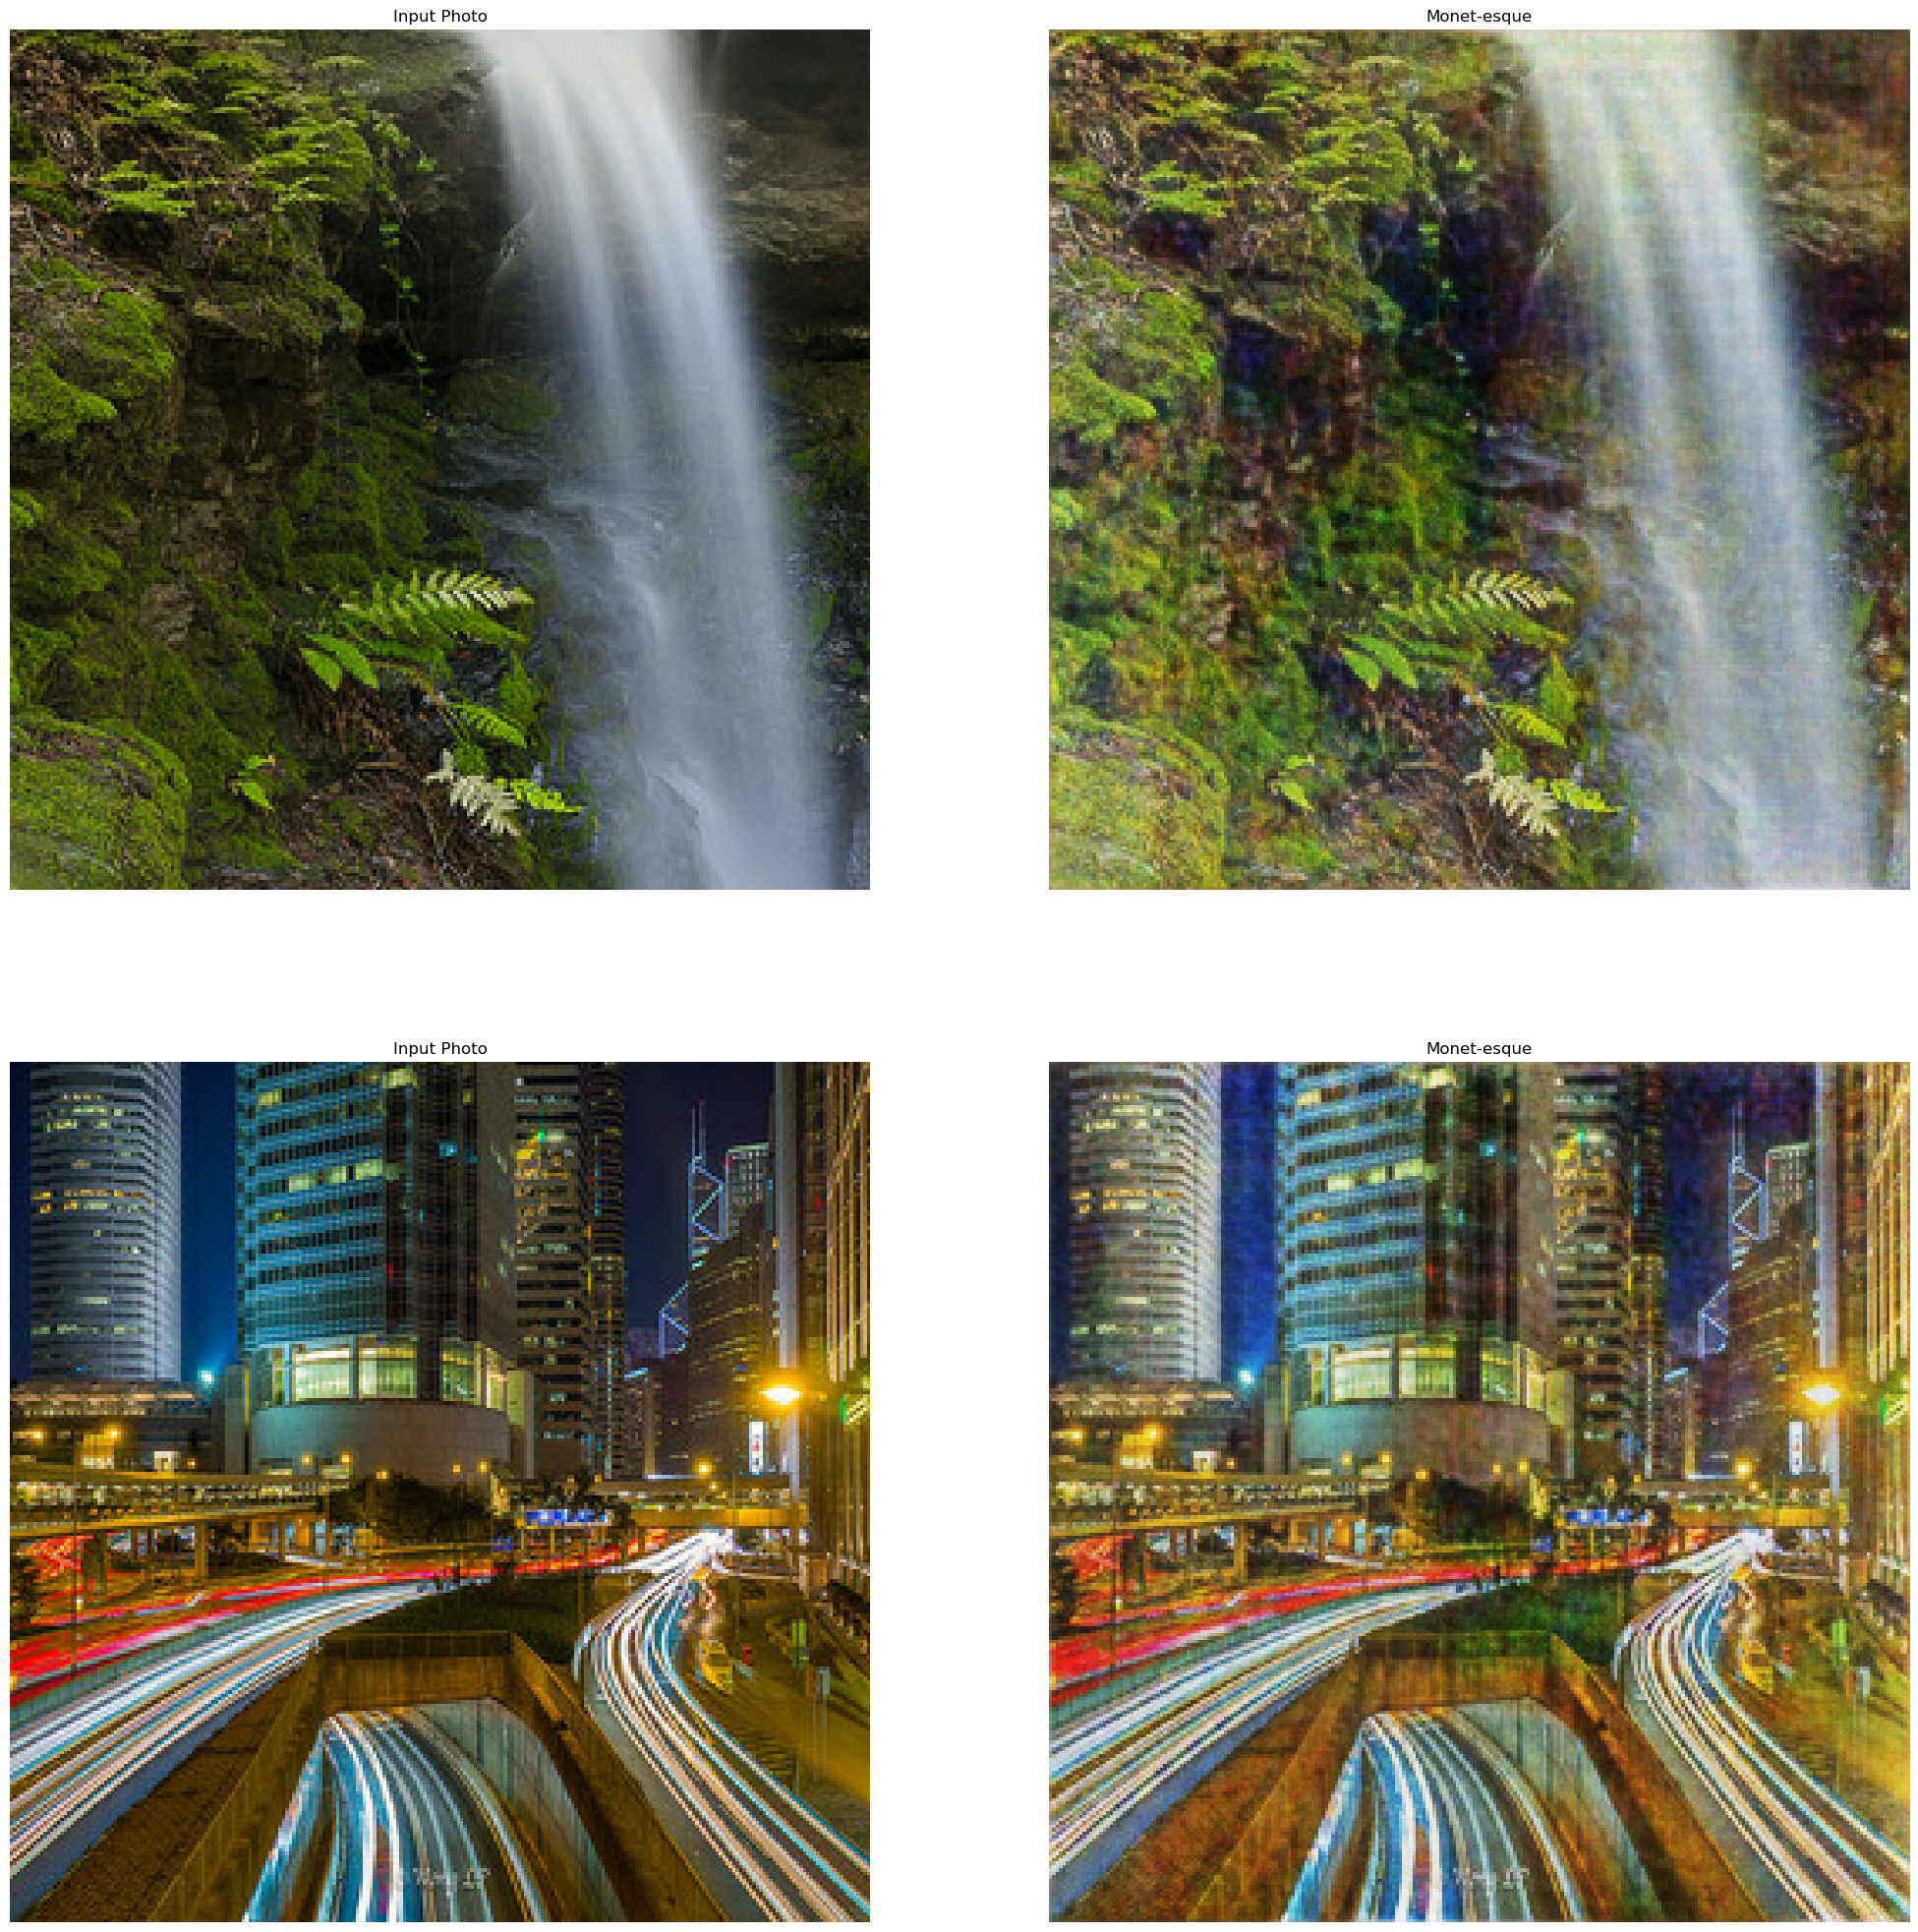

In [10]:
n = 10
photos = [p for p in PHOTOS_DATASET.take(n)]
_, ax = plt.subplots(2, 2, figsize=(50, 50))
for i, img in enumerate(photos[:2]):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
n = 2
_, ax = plt.subplots(2, 2, figsize=(25, 25))
for i, img in enumerate(photos[2:4]):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
_, ax = plt.subplots(2, 2, figsize=(25, 25))
for i, img in enumerate(photos[4:6]):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
_, ax = plt.subplots(2, 2, figsize=(25, 25))
for i, img in enumerate(photos[6:8]):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()